## Supervised learning: предсказание удовлетворённости жизнью

### Импорт библиотек

In [46]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    roc_curve,
)

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns



### Загрузка очищенных данных

In [47]:
PROJECT_ROOT = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "cleaned_data.csv")

df = pd.read_csv(DATA_PATH)
df.head()


,timestamp,age_group,gender,status,sleep_duration,sleep_quality,night_awakenings,nap_frequency,nap_duration,nap_time,...,screen_time_late,screen_sleep_impact,life_satisfaction_current,life_satisfaction_month,satisfaction_work,satisfaction_social,satisfaction_health,satisfaction_emotional,night_awakenings_raw,night_awakenings_3plus
0,2025-12-20 20:04:51,22–25,Female,Working and studying,7–8 hours,7.0,0.0,Never,I do not nap,I do not nap,...,>2 hours,Minor impact,7.0,7.0,8.0,7.0,6.0,4.0,0,0
1,2025-12-20 16:57:12,18–21,Male,Student,7–8 hours,7.0,2.0,Never,I do not nap,I do not nap,...,1–2 hours,Moderate negative impact,8.0,6.0,8.0,7.0,8.0,5.0,2,0
2,2025-12-20 16:26:50,18–21,Male,Student,6–7 hours,6.0,1.0,Never,20–40 min,After 16:00,...,30–60 min,Moderate negative impact,7.0,6.0,5.0,7.0,8.0,7.0,1,0
3,2025-12-20 16:23:31,18–21,Female,Student,6–7 hours,7.0,0.0,1–2 times per week,20–40 min,After 16:00,...,1–2 hours,Moderate negative impact,7.0,9.0,6.0,6.0,7.0,7.0,0,0
4,2025-12-20 16:19:20,18–21,Male,Student,6–7 hours,9.0,0.0,Never,I do not nap,I do not nap,...,30–60 min,Minor impact,7.0,7.0,6.0,7.0,7.0,7.0,0,0


### Выбор целевой переменной

### Создание бинарной целевой переменной

In [48]:
# 1 — высокий стресс, 0 — низкий / умеренный
df["high_stress"] = (df["stress_current"] >= 7).astype(int)

# Проверка
df["high_stress"].value_counts()


high_stress
1    60
0    47
Name: count, dtype: int64

In [49]:
y = df["high_stress"]

### Выбор признаков
В модель включены:
- показатели сна,
- поведенческие привычки,
- психоэмоциональные показатели (кроме стресса, так как он используется в таргете).

In [50]:
feature_cols = [
    # Сон
    "sleep_quality",
    "night_awakenings",
    "night_awakenings_3plus",

    # Экраны
    "screen_time_daily",
    "screen_time_late",
    "screen_sleep_impact",

    # Образ жизни
    "workouts_per_week",
    "diet_quality",
    "caffeine_daily",

    # Психоэмоциональные показатели
    "stress_current",
    "anxiety_current",
    "fatigue_current"
]

X = df[feature_cols]

### Кодирование категориальных признаков

In [51]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,sleep_quality,night_awakenings,night_awakenings_3plus,diet_quality,stress_current,anxiety_current,fatigue_current,screen_time_daily_4–6 hours,screen_time_daily_6–8 hours,screen_time_daily_<2 hours,...,screen_time_late_>2 hours,screen_sleep_impact_Moderate negative impact,screen_sleep_impact_No impact,screen_sleep_impact_Strong negative impact,workouts_per_week_1–2,workouts_per_week_3–4,workouts_per_week_5 or more,caffeine_daily_1,caffeine_daily_2,caffeine_daily_3 or more
0,7.0,0.0,0,5.0,8.0,8.0,5.0,False,True,False,...,True,False,False,False,False,True,False,True,False,False
1,7.0,2.0,0,7.0,7.0,7.0,6.0,False,True,False,...,False,True,False,False,False,True,False,False,False,False
2,6.0,1.0,0,8.0,8.0,6.0,8.0,True,False,False,...,False,True,False,False,False,True,False,False,True,False
3,7.0,0.0,0,4.0,8.0,8.0,6.0,False,True,False,...,False,True,False,False,False,True,False,False,False,False
4,9.0,0.0,0,4.0,6.0,4.0,4.0,True,False,False,...,False,False,False,False,True,False,False,False,False,False


###     Разделение на обучающую и тестовую выборки

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Контроль
print("Train classes:", np.unique(y_train))
print("Test classes:", np.unique(y_test))



Train classes: [0 1]
Test classes: [0 1]


### Масштабирование признаков
Масштабирование применяется только для логистической регрессии.

In [53]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline модель - **линейная регрессия**
Логистическая регрессия используется как интерпретируемая базовая модель.
Для учёта дисбаланса классов применяется параметр class_weight="balanced".

In [54]:
log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight="balanced"
)

log_reg.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

### Основная модель - **Random Forest**
Random Forest используется для выявления нелинейных связей
между признаками и высоким уровнем стресса.

In [55]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

### Предсказания

In [56]:
# Logistic Regression
y_pred_log = log_reg.predict(X_test_scaled)
y_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]

# Random Forest
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]


### Оценка качества моделей
Для оценки используются стандартные метрики классификации,
включая Precision, Recall, F1-score, ROC-AUC и PR-AUC.

In [57]:
def evaluate_model(y_true, y_pred, model_name):
    print(f" {model_name} ")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print()

evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")


 Logistic Regression 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.93      0.93      0.93        15

    accuracy                           0.93        27
   macro avg       0.93      0.93      0.93        27
weighted avg       0.93      0.93      0.93        27

Confusion Matrix:
 [[11  1]
 [ 1 14]]

 Random Forest 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        15

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

Confusion Matrix:
 [[12  0]
 [ 0 15]]



### Confusion Matrix

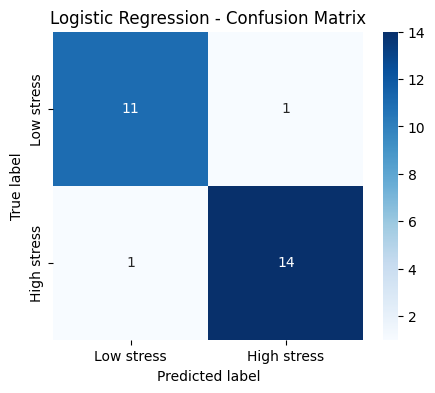

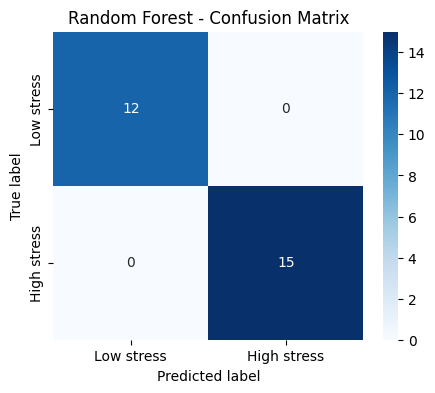

In [58]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Low stress", "High stress"],
        yticklabels=["Low stress", "High stress"]
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_log, "Logistic Regression - Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest - Confusion Matrix")

### ROC-AUC и PR-AUC

In [59]:
def safe_auc_metrics(y_true, y_prob, model_name):
    print(model_name)

    if len(np.unique(y_true)) == 2:
        print("ROC-AUC:", roc_auc_score(y_true, y_prob))
        print("PR-AUC:", average_precision_score(y_true, y_prob))
    else:
        print("ROC-AUC: not defined (only one class in y_test)")
        print("PR-AUC: not defined (only one class in y_test)")

    print()


safe_auc_metrics(y_test, y_prob_log, "Logistic Regression")
safe_auc_metrics(y_test, y_prob_rf, "Random Forest")

Logistic Regression
ROC-AUC: 0.9722222222222222
PR-AUC: 0.9759432234432235

Random Forest
ROC-AUC: 1.0
PR-AUC: 1.0



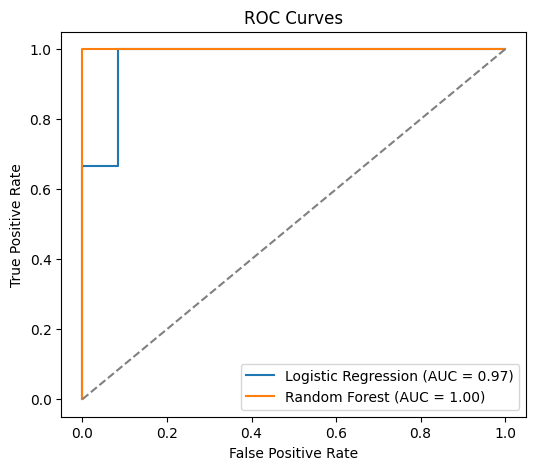

In [60]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(6, 5))

# Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
plt.plot(
    fpr_log, tpr_log,
    label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_log):.2f})"
)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(
    fpr_rf, tpr_rf,
    label=f"Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})"
)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


### Model Performance Comparison

In [61]:
metrics_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        (y_pred_log == y_test).mean(),
        (y_pred_rf == y_test).mean()
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_prob_log),
        roc_auc_score(y_test, y_prob_rf)
    ],
    "PR-AUC": [
        average_precision_score(y_test, y_prob_log),
        average_precision_score(y_test, y_prob_rf)
    ]
})

metrics_df


,Model,Accuracy,ROC-AUC,PR-AUC
0,Logistic Regression,0.925926,0.972222,0.975943
1,Random Forest,1.000000,1.000000,1.000000


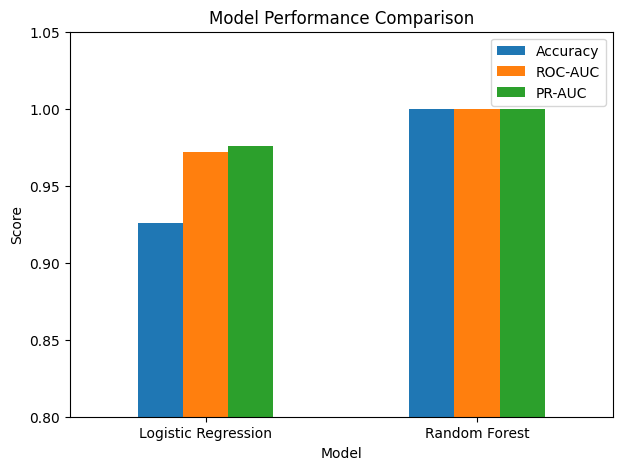

In [62]:
metrics_df.set_index("Model").plot(
    kind="bar",
    figsize=(7, 5)
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.8, 1.05)
plt.xticks(rotation=0)
plt.show()
